In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft, fftfreq
from scipy.io import loadmat
%matplotlib inline

In [2]:
def NGD(x,alpha,beta,K,g,phi):
    y=np.zeros(len(x))
    z=np.zeros(len(x))
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j]+K*(x[j]-phi*z[j]))
        dz=dt*(-beta*z[j]+g*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    return y,z

In [3]:
# NGD orignal model with constant time memory
def NGD_const(x,alpha,tau_NGD,K):
    y=np.zeros(len(T))
    z=np.zeros(len(T))
    for k in range(len(T)-1):
        if T[k]>tau_NGD:
            F=y[k-int(tau_NGD/dt)]
        else:
            F=0
        dy=dt*(-alpha*y[k]+K*(x[k]-F))
        y[k+1]=y[k]+dy
    return y,z

In [4]:
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [5]:
def MI(xstate,ystate,dt,window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftdu=dt # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen))
    xedges=np.arange(min(xstate),max(xstate)+0.0001)
    yedges=np.arange(min(ystate),max(ystate)+0.0001)
    
    # shifted data
    # shift>0 => y shifted to positive side
    MIvalue=np.zeros(len(bitshift))
    for i in range(len(bitshift)):
        xx=[]
        yy=[]
        shift=int(bitshift[i])
        if shift>0:
            xx=xstate[shift:]
            yy=ystate[:-shift]
        elif shift==0:
            xx=xstate
            yy=ystate
        elif shift<0:
            xx=xstate[:shift]
            yy=ystate[-shift:]

        H, xedges, yedges = np.histogram2d(xx, yy, bins=(xedges, yedges))
        statesum=np.sum(H)
        px_list=np.sum(H,axis=1)/statesum
        py_list=np.sum(H,axis=0)/statesum
        pxy_list=H/statesum

        MIsingle=np.zeros((len(px_list),len(py_list)))
        for ix in range(len(px_list)):
            for iy in range(len(py_list)):
                if pxy_list[ix][iy]==0:
                    MIsingle[ix][iy]=0
                else:
                    MIsingle[ix][iy]=pxy_list[ix][iy]*math.log2(pxy_list[ix][iy]/px_list[ix]/py_list[iy])/dt
        MIvalue[i]=np.sum(MIsingle)
    return timeshift,MIvalue

In [6]:
def FFT_quick(data):
    Ts=dt
    xft=fft(data)
    xftreal = xft.real  
    xftimg = xft.imag
    xft_abs=abs(xft)
    xft_nor=xft_abs/len(xft_abs)
    xft_nor2=xft_nor[range(int(len(xft_nor)/2))]
    freq=fftfreq(len(x), d=dt)
    freq=freq[range(int(len(freq)/2))]
    phase=np.angle(xft)
    phase=phase[range(int(len(phase)/2))]
    
    return freq,xft_nor2,phase

In [7]:
# # generate OU
# Tot=300
# dt=0.01
# T=np.arange(dt,Tot,dt)
# tau=1
# D = 4
# L=np.zeros(len(T))
# mu, sigma = 0, 1
# for i in range(len(T)-1):
#     L[i+1]=L[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# # filtering
# fc=[10,7,4,2]
# x_set=[L]
# for ifc in range(len(fc)):
#     b, a = signal.butter(2, 2*fc[ifc]*dt, btype='low', analog=False)
#     Lf = signal.filtfilt(b, a, L)
#     x_set.append(Lf)
    
# for i in range(np.size(x_set,0)):
#     plt.plot(T,x_set[i])
# plt.xlim(150,152)

In [8]:
dt=0.01
T=np.arange(dt,300,dt)
mu, sigma = 0, 1 # mean and standard deviation
x = np.random.normal(mu, sigma, len(T))

In [10]:
alpha,beta,K,g=6,1.6,22,10
y,z=NGD(x,alpha,beta,K,g,1)
#     y_set[i],z_set[i]=NGD(x_set[i],8,1.4,37,10,1)

In [13]:
MI_set=[[] for i in range(len(x))]
timeshift,MIdata=MI(EqualState(x,8),EqualState(y,8),dt,[-1,1])

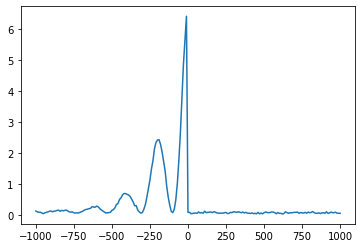

In [15]:
plt.plot(timeshift*1000,MIdata) 

In [19]:
# find cross correlation as simulated STA
corr_same=np.correlate(x,y,'same')
corr=corr_same[int(len(corr_same+1)/2)-int(1/dt):int(len(corr_same+1)/2)+int(1/dt)]
corr=corr/max(abs(corr))
timelag=np.arange(-int(1/dt),int(1/dt))*dt 

(-1.0995, 1.0895)

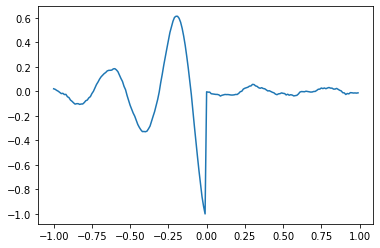

In [23]:
colorlist=['#1f77b4','#ff7f0e','#d62728','#9467bd','#2ca02c']
plt.plot(timelag,-corr)
plt.xlim()